# 데이터 불러오기 및 라벨링

### step1: 질병이 있음/없음만 구분

In [1]:
import os 
# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, abnormal: 1
label_map = {
    'Aom': 1,
    'Chornic': 1,
    'Earwax': 1,
    'Normal': 0,
    'OtitExterna': 1,
    'tympanoskleros': 1
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# 제외 폴더
exclude_folders = {'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, image_filename))
        image_labels.append(label_map[label_folder])

In [2]:
print(image_paths[1:5])

['/home/jeonk636/ear_classification/eardrumDs/Aom/aom_10.tiff', '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_100.tiff', '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_101.tiff', '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_102.tiff']


In [3]:
print(image_labels[0:500])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [4]:
print(os.getcwd())

/home/jeonk636/ear_classification


In [5]:
# 라벨 0과 라벨 1의 개수를 계산.
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)

(label_0_count, label_1_count)

(534, 396)

Aom_cnt = 120  
Chornic_cnt = 64  
Earwax_cnt = 141  
Normal_cnt = 534  
OtitExterna_cnt = 42  
tympanoskleros_cnt = 29  

In [6]:
path1 = '/home/jeonk636/ear_classification/eardrumDs/tympanoskleros'
files_in_folder = os.listdir(path1)
# 파일 개수를 출력.
print(len(files_in_folder))

29


# Split the Dataset

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 전체 데이터를 훈련+검증 세트와 테스트 세트로 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(
    image_paths, image_labels, stratify=image_labels, test_size=0.2, random_state=42)

# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

# 결과 출력
print("Train set:", len(x_train))
print("Validation set:", len(x_val))
print("Test set:", len(x_test))

Train set: 595
Validation set: 149
Test set: 186


# train dataset을 Augmentation

### 목표: 정상 이미지 1000장, 비정상 이미지 1000장

#### 여러종류의 증강함수를 만들고 나중에 비율을 정해서 적용하기

### 1. Spatial-Level Transforms

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

2024-04-23 08:43:07.100924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 08:43:07.140006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 08:43:07.140027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 08:43:07.141215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 08:43:07.148170: I tensorflow/core/platform/cpu_feature_guar

In [9]:
print(tf.__version__)

2.15.0


In [10]:
def flip_H(image):
    flipped_H = tf.image.flip_left_right(image)
    return flipped_H

def flip_V(image):
    flipped_V = tf.image.flip_up_down(image)
    return flipped_V

def rotate(image, degrees):
    rotated = tf.image.rot90(image, k=degrees // 90)
    return rotated

def crop(image):
    cropped = tf.image.central_crop(image, central_fraction=0.5)
    return cropped

In [18]:
# 이미지 파일을 로드하고 텐서로 변환하는 함수
def load_and_preprocess_image(path):
    image = Image.open(path)
    image = image.convert('RGB')  # PIL 이미지를 RGB로 변환 (필요한 경우)
    image = np.array(image)       # NumPy 배열로 변환
    image = tf.image.convert_image_dtype(image, tf.float32)  # TensorFlow 텐서로 변환
    return image

# 이미지 경로로부터 이미지를 로드
image_path = x_train_all[0]  # 예시 이미지 경로
image = load_and_preprocess_image(image_path)

Spatial_aug = {
    'flip_H': flip_H(image),
    'flip_V': flip_V(image),
    'rotate': rotate(image, degrees=270),
    'crop': crop(image)
}

# 이미지를 시각화하기 위한 함수
def visualize_Spatial(image, Spatial_aug):
    fig, axes = plt.subplots(1, len(Spatial_aug) + 1, figsize=(20, 10))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, (augmentation_name, augmented_image) in enumerate(Spatial_aug.items(), 1):
        axes[i].imshow(augmented_image)
        axes[i].set_title(augmentation_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

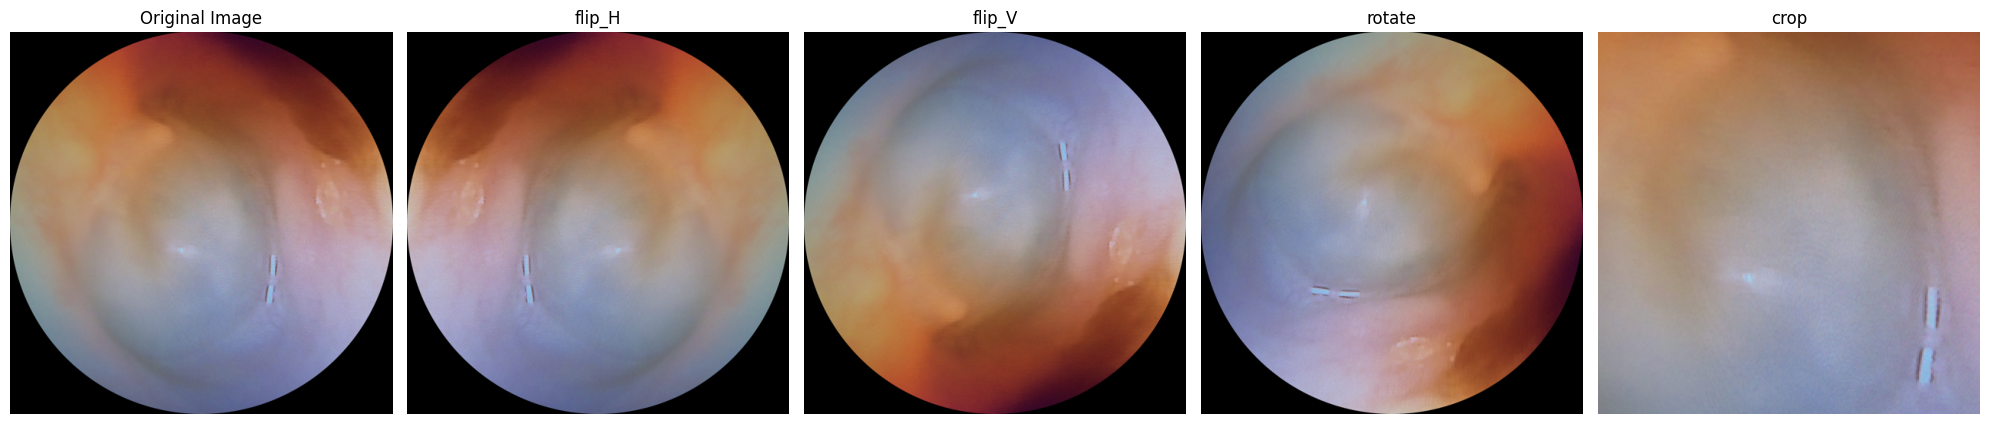

In [19]:
visualize_Spatial(image, Spatial_aug)

### 2.Pixel-Level Transforms

In [13]:
def CLAHE(image):
    # TensorFlow 텐서를 NumPy 배열로 변환하고 0-255 범위의 값으로 조정
    image = (image.numpy() * 255).astype(np.uint8)
    # RGB 채널을 BGR로 변경
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # 각 채널에 CLAHE 적용
    channels = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahed_channels = [clahe.apply(c) for c in channels]
    clahed_image = cv2.merge(clahed_channels)
    # 다시 RGB 채널로 변경
    clahed_image = cv2.cvtColor(clahed_image, cv2.COLOR_BGR2RGB)
    # 이미지를 [0, 1] 범위로 정규화
    clahed_image = clahed_image / 255.0
    return clahed_image
    
def Hue(image):
    # HueSaturationValue
    hue_img = tf.image.adjust_hue(image, delta=0.1)
    hue_img = tf.image.adjust_saturation(hue_img, saturation_factor=1)
    return hue_img

def RandomContrast(image):
    # 이미지에 RandomContrast를 적용하고 결과를 [0, 1] 범위로 클리핑
    contrast_image = tf.image.random_contrast(image, lower=1.0, upper=3.0)
    contrast_image = tf.clip_by_value(contrast_image, 0.0, 1.0)  # 클리핑
    return contrast_image

def RandomGamma(image):
    # RandomGamma
    gamma_img = tf.image.adjust_gamma(image, gamma=0.5)
    return gamma_img

def RandomBrightness(image):
    # 이미지에 RandomBrightness를 적용하고 결과를 [0, 1] 범위로 클리핑
    bright_image = tf.image.random_brightness(image, max_delta=0.3)
    bright_image = tf.clip_by_value(bright_image, 0.0, 1.0)  # 클리핑
    return bright_image

def Blur(image):
    # TensorFlow 텐서를 NumPy 배열로 변환
    image = image.numpy()
    blur_img = cv2.blur(image, (5, 5))
    return blur_img

def gray(image):
    # ToGray
    togray_img = tf.image.rgb_to_grayscale(image)
    return togray_img

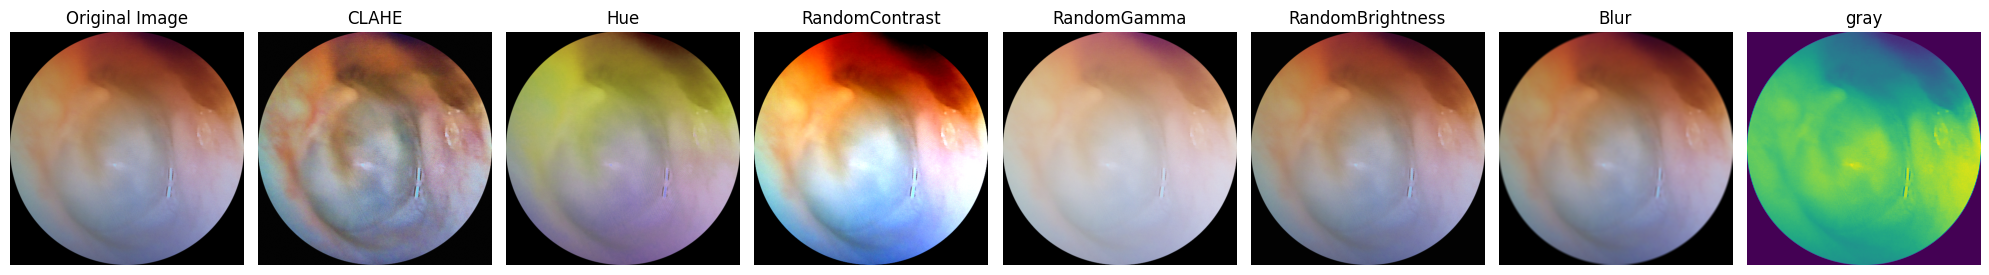

In [15]:
# 시각화를 위한 함수
def visualize_augmentations(image, augmentations):
    fig, axes = plt.subplots(1, len(augmentations) + 1, figsize=(20, 10))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, (augmentation_name, augmented_image) in enumerate(augmentations.items(), 1):
        axes[i].imshow(augmented_image)
        axes[i].set_title(augmentation_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 각 증강 기법을 적용합니다.
augmentations = {
    'CLAHE': CLAHE(image),
    'Hue': Hue(image),
    'RandomContrast': RandomContrast(image),
    'RandomGamma': RandomGamma(image),
    'RandomBrightness': RandomBrightness(image),
    'Blur': Blur(image),
    'gray': gray(image)
}

# 시각화 실행
visualize_augmentations(image, augmentations)